In [1]:
import sys
sys.path.append("../codes/")
from Readfiles import getFnames
from DCdata import readReservoirDC
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG.EM.Static import DC
from SimPEG import EM
from SimPEG import Mesh
from SimPEG.Survey import Data
def removeRxsfromDC(survey, inds, DClow=-np.inf, DChigh=np.inf, surveyType="2D"):
    srcList = survey.srcList
    srcListNew = []
    dobs = survey.dobs
    dobs[inds] = np.nan
    data = Data(survey, survey.dobs)
    rxData = []
    for iSrc, src in enumerate(srcList):
        rx = src.rxList[0]
        data_temp = data[src, rx]        
        rxinds = np.isnan(data_temp) | (np.logical_or(DClow>data_temp, DChigh<data_temp))
        nrxact_temp = rxinds.sum()
        nrx_temp = len(rxinds)
        rxlocM = rx.locs[0]
        rxlocN = rx.locs[1]
        srcloc = src.loc
        rxData.append(data_temp[~rxinds])
        # All Rxs are active
        if  nrxact_temp == 0:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM, rxlocN)
            else:
                rxNew = DC.Rx.Dipole(rxlocM, rxlocN)
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)            
        # All Rxs are nan then remove src
        elif nrx_temp == nrxact_temp:
            print ("Remove %i-th Src") % (iSrc)
        # Some Rxs are not active
        else:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            else:
                rxNew = DC.Rx.Dipole(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)
    if surveyType == "2D":                            
        surveyNew = DC.Survey_ky(srcListNew)
    else:
        surveyNew = DC.Survey(srcListNew)                          
    surveyNew.dobs = np.hstack(rxData)
    return surveyNew

In [3]:
EM.Static.Utils.StaticUtils.plot_pseudoSection?

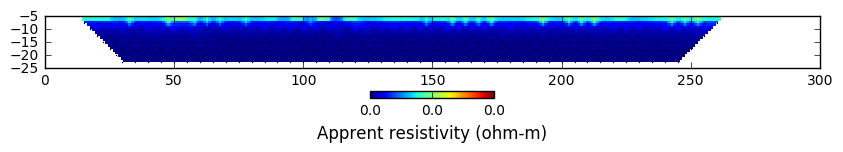

In [4]:
fname = "../data/ChungCheonDC/20150820000000.apr"
survey = readReservoirDC(fname)
dobsAppres = survey.dobs
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax)
cb = dat[2]
cb.set_label("Apprent resistivity (ohm-m)")
geom = np.hstack(dat[3])
dobsDC = dobsAppres * geom

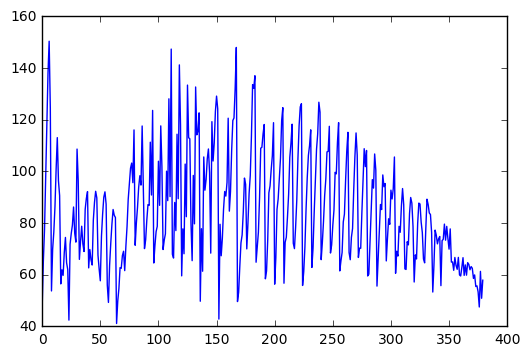

In [5]:
plt.plot(abs(dobsAppres))

In [6]:
np.argwhere(dobsAppres>160.)

array([], shape=(0, 1), dtype=int64)

In [7]:
# print dobsAppres[6:]

/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in greater


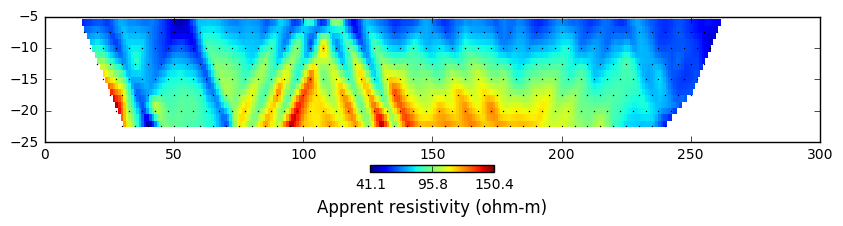

In [8]:
# surveyNew = removeRxsfromDC(survey, [346], DClow=40, DChigh=145, surveyType="2D")
surveyNew = removeRxsfromDC(survey, [330], surveyType="2D")
surveyNew = removeRxsfromDC(survey, [338], surveyType="2D")
surveyNew = removeRxsfromDC(survey, [346], surveyType="2D")
surveyNew = removeRxsfromDC(survey, [351], surveyType="2D")
surveyNew = removeRxsfromDC(survey, [358], surveyType="2D")

fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='volt', sameratio=False)
cb = dat[2]
cb.set_label("Apprent resistivity (ohm-m)")
geom = np.hstack(dat[3])
dobsDC = surveyNew.dobs * geom

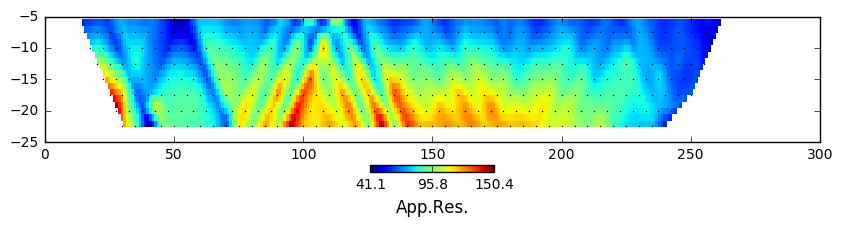

In [9]:
surveyNew.dobs = dobsDC
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False)

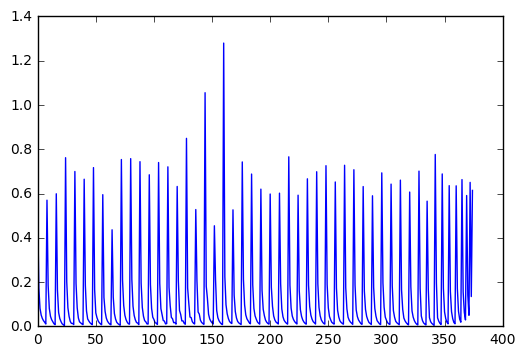

In [10]:
plt.plot(abs(dobsDC))

In [11]:
# problem = DC.Problem2D_CC(mesh)
cs = 2.5
npad = 6
hx = [(cs,npad, -1.3),(cs,160),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,20)]
mesh = Mesh.TensorMesh([hx, hy])
mesh = Mesh.TensorMesh([hx, hy],x0=[-mesh.hx[:6].sum()-0.25, -mesh.hy.sum()])

In [12]:
def from3Dto2Dsurvey(survey):
    srcLists2D = []
    nSrc = len(survey.srcList)

    for iSrc in range (nSrc):
        src = survey.srcList[iSrc]
        locsM = np.c_[src.rxList[0].locs[0][:,0], np.ones_like(src.rxList[0].locs[0][:,0])*-0.75] 
        locsN = np.c_[src.rxList[0].locs[1][:,0], np.ones_like(src.rxList[0].locs[1][:,0])*-0.75] 
        rx = DC.Rx.Dipole_ky(locsM, locsN)
        locA = np.r_[src.loc[0][0], -0.75]
        locB = np.r_[src.loc[1][0], -0.75]
        src = DC.Src.Dipole([rx], locA, locB)
        srcLists2D.append(src)
    survey2D = DC.Survey_ky(srcLists2D)
    return survey2D

In [13]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
# from pymatsolver import MumpsSolver

In [14]:
mapping = Maps.ExpMap(mesh)
survey2D = from3Dto2Dsurvey(surveyNew)
problem = DC.Problem2D_N(mesh, mapping=mapping)
problem.pair(survey2D)
# problem.Solver = MumpsSolver
m0 = np.ones(mesh.nC)*np.log(1e-2)

<function __main__.foo>

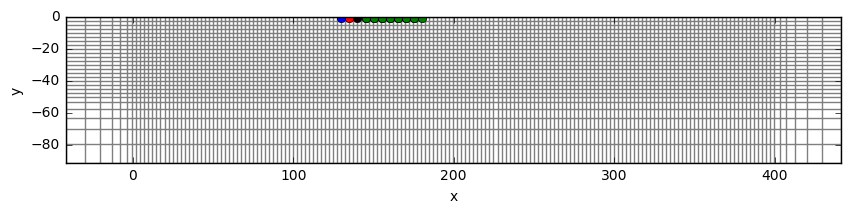

In [15]:
from ipywidgets import interact
nSrc = len(survey2D.srcList)
def foo(isrc):
    figsize(10, 5)
    mesh.plotImage(np.ones(mesh.nC)*np.nan, gridOpts={"color":"k", "alpha":0.5}, grid=True)
#     isrc=0
    src = survey2D.srcList[isrc]
    plt.plot(src.loc[0][0], src.loc[0][1], 'bo')
    plt.plot(src.loc[1][0], src.loc[1][1], 'ro')
    locsM = src.rxList[0].locs[0]
    locsN = src.rxList[0].locs[1]
    plt.plot(locsM[:,0], locsM[:,1], 'ko')
    plt.plot(locsN[:,0], locsN[:,1], 'go')
    plt.gca().set_aspect('equal', adjustable='box')
    
interact(foo, isrc=(0, nSrc-1, 1))

In [16]:
pred = survey2D.dpred(m0)

In [17]:
# data_anal = []
# nSrc = len(survey.srcList)
# for isrc in range(nSrc):
#     src = survey.srcList[isrc]    
#     locA = src.loc[0]
#     locB = src.loc[1]
#     locsM = src.rxList[0].locs[0]
#     locsN = src.rxList[0].locs[1]
#     rxloc=[locsM, locsN]
#     a = EM.Analytics.DCAnalyticHalf(locA, rxloc, 1e-3, earth_type="halfspace")
#     b = EM.Analytics.DCAnalyticHalf(locB, rxloc, 1e-3, earth_type="halfspace")
#     data_anal.append(a-b)
# data_anal = np.hstack(data_anal)

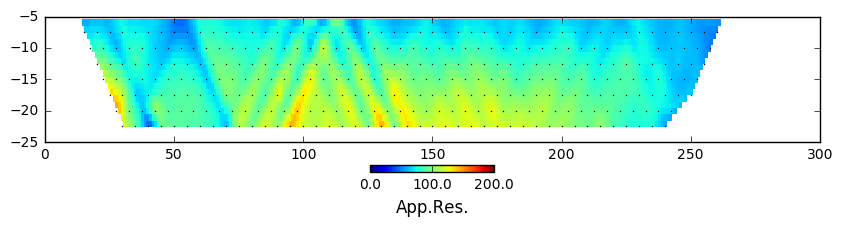

In [18]:
survey.dobs = pred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, scale="linear", clim=(0, 200))

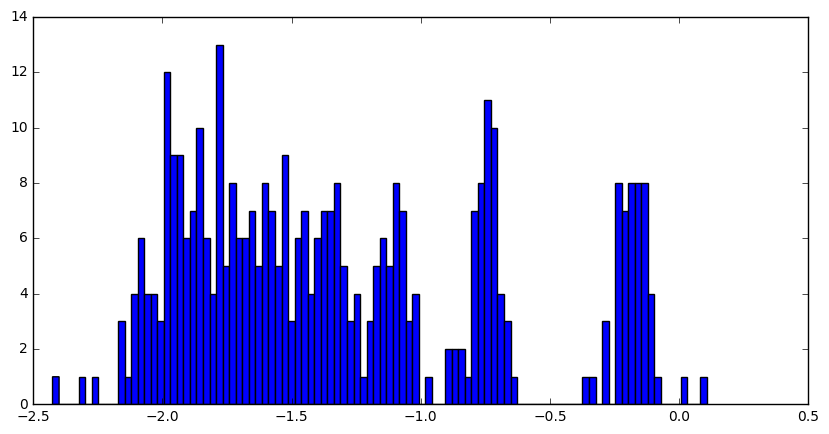

In [19]:
out = hist(np.log10(abs(dobsDC)), bins = 100)

In [20]:
weight =  1./abs(mesh.gridCC[:,1])**1.5

(<matplotlib.collections.QuadMesh at 0x1102bc0d0>,)

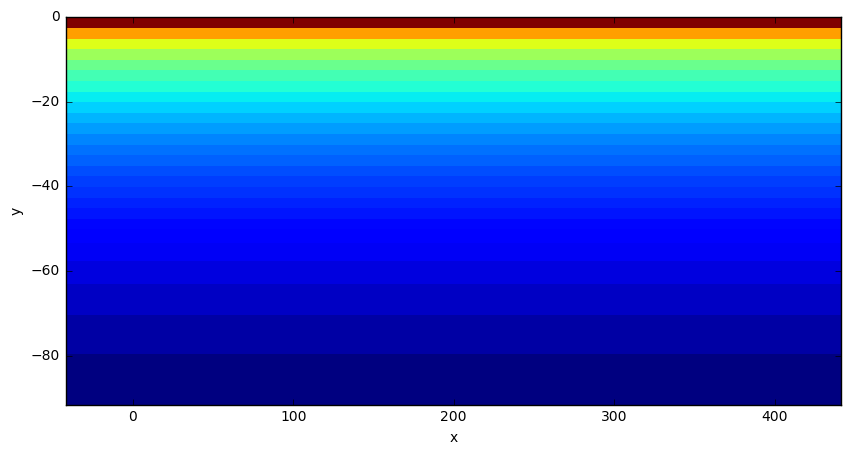

In [21]:
mesh.plotImage(np.log10(weight))

In [22]:
survey2D.dobs = dobsDC
survey2D.eps = 10**(-2.3)
survey2D.std = 0.02
dmisfit = DataMisfit.l2_DataMisfit(survey2D)
regmap = Maps.IdentityMap(nP=int(mesh.nC))
reg = Regularization.Simple(mesh,mapping=regmap,cell_weights=weight)

opt = Optimization.ProjectedGNCG(maxIter=10)
opt.upper = np.log(1e0)
opt.lower = np.log(1./300)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  7.18e+02  2.80e+04  0.00e+00  2.80e+04    1.10e+02      0              
   1  7.18e+02  3.33e+03  5.53e+00  7.30e+03    6.73e+01      0              
   2  1.44e+02  2.50e+03  6.42e+00  3.42e+03    8.25e+01      0   Skip BFGS  
   3  1.44e+02  4.26e+02  1.22e+01  2.18e+03    3.44e+01      0              
   4  2.87e+01  4.02e+02  1.23e+01  7.56e+02    6.70e+01      0              
   5  2.87e+01  2.04e+02  1.50e+01  6.35e+02    7.18e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(

In [23]:
xc = opt.recall("xc")

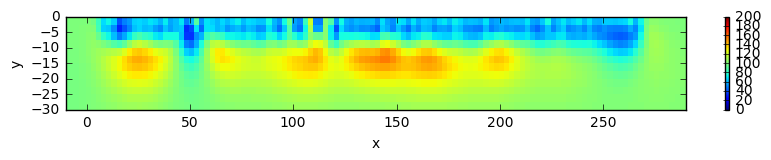

In [33]:
fig, ax = plt.subplots(1,1, figsize = (10, 1.2))
iteration = 5
sigma = mapping*xc[iteration]
dat = mesh.plotImage(1./sigma, grid=False, ax=ax, pcolorOpts={"cmap":"jet"}, clim=(0, 200))
ax.set_ylim(-30, 0)
ax.set_xlim(-10, 290)
plt.colorbar(dat[0])

In [34]:
print np.log10(sigma).min(), np.log10(sigma).max()

-2.19194828988 -1.49999173623


In [35]:
1./sigma.max()

31.622174888027711

In [36]:
1./sigma.min()

155.5780378559127

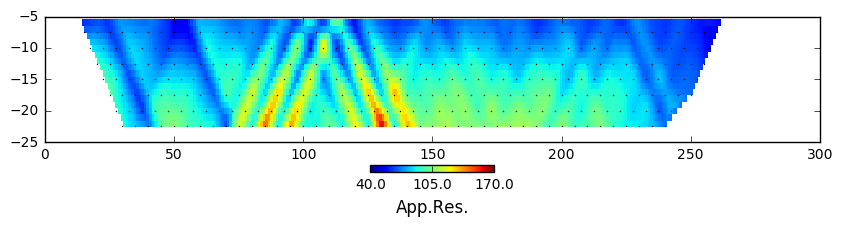

In [37]:
surveyNew.dobs = invProb.dpred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, clim=(40, 170))

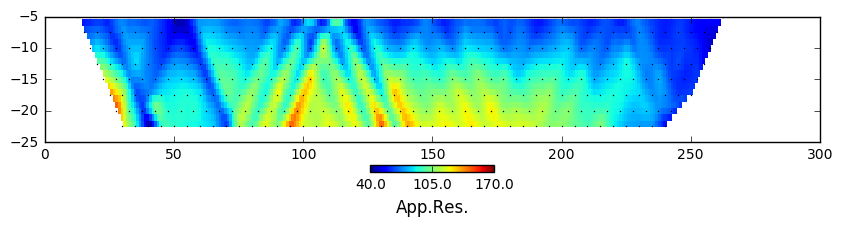

In [38]:
surveyNew.dobs = dobsDC
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, clim=(40, 170))

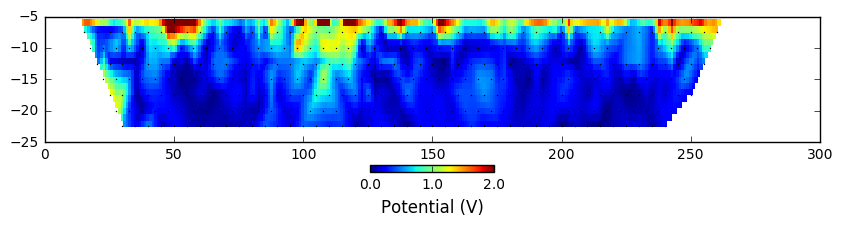

In [39]:
surveyNew.dobs = abs(dmisfit.Wd*(dobsDC-invProb.dpred))
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='volt', sameratio=False, clim=(0, 2))

In [40]:
# sigma = np.ones(mesh.nC)
modelname = "sigma0820NBound.npy"
np.save(modelname, sigma)